In [ ]:
import pandas as pd
import pickle
import numpy as np
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import load_model, Model
from keras.layers import Flatten, Dense, Dropout, Activation, Input, LSTM, Reshape, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.layers import LeakyReLU
#!pip install np_utils
from keras import utils

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

# set random seeds

# removed the import statement for set_session from tensorflow.compat.v1.keras.backend
np.random.seed(1)
tf.random.set_seed(2)

## Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Dataset

In [ ]:
import os
if not os.path.isfile('/content/drive/MyDrive/LOBCNN/data/data.zip'):
    !wget https://raw.githubusercontent.com/zcakhaa/DeepLOB-Deep-Convolutional-Neural-Networks-for-Limit-Order-Books/master/data/data.zip
    !unzip -n data.zip
    print('data downloaded.')
else:
    print('data already existed.')

data already existed.


# Functions for pre-processing:


In [ ]:
def prepare_x(data):
    df1 = data[:40, :].T
    return np.array(df1)

def get_label(data):
    lob = data[-5:, :].T
    return lob

def data_classification(X, Y, T):
    [N, D] = X.shape
    df = np.array(X)
    dY = np.array(Y)
    dataY = dY[T - 1:N]
    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]
    return dataX.reshape(dataX.shape + (1,)), dataY

def prepare_x_y(data, k, T):
    x = prepare_x(data)
    y = get_label(data)
    x, y = data_classification(x, y, T=T)
    y = y[:,k] - 1
    y = utils.to_categorical(y, 3)
    return x, y

In [ ]:
dec_data = np.loadtxt('/content/drive/MyDrive/DeepLOB-Deep-Convolutional-Neural-Networks-for-Limit-Order-Books-master/data/data.zip (Unzipped Files)/Train_Dst_NoAuction_DecPre_CF_7.txt')
dec_train = dec_data[:, :int(np.floor(dec_data.shape[1] * 0.8))]
dec_val = dec_data[:, int(np.floor(dec_data.shape[1] * 0.8)):]

dec_test1 = np.loadtxt('/content/drive/MyDrive/DeepLOB-Deep-Convolutional-Neural-Networks-for-Limit-Order-Books-master/data/data.zip (Unzipped Files)/Test_Dst_NoAuction_DecPre_CF_7.txt')
dec_test2 = np.loadtxt('/content/drive/MyDrive/DeepLOB-Deep-Convolutional-Neural-Networks-for-Limit-Order-Books-master/data/data.zip (Unzipped Files)/Test_Dst_NoAuction_DecPre_CF_8.txt')
dec_test3 = np.loadtxt('/content/drive/MyDrive/DeepLOB-Deep-Convolutional-Neural-Networks-for-Limit-Order-Books-master/data/data.zip (Unzipped Files)/Test_Dst_NoAuction_DecPre_CF_9.txt')
dec_test = np.hstack((dec_test1, dec_test2, dec_test3))

k = 4 # which prediction horizon
T = 100 # the length of a single input
n_hiddens = 64
checkpoint_filepath = './model_tensorflow1_weights'

trainX_CNN, trainY_CNN = prepare_x_y(dec_train, k, T)
valX_CNN, valY_CNN = prepare_x_y(dec_val, k, T)
testX_CNN, testY_CNN = prepare_x_y(dec_test, k, T)

print(trainX_CNN.shape, trainY_CNN.shape)
print(valX_CNN.shape, valY_CNN.shape)
print(testX_CNN.shape, testY_CNN.shape)

(203701, 100, 40, 1) (203701, 3)
(50851, 100, 40, 1) (50851, 3)
(139488, 100, 40, 1) (139488, 3)


# Model

In [ ]:

from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout, Reshape

def create_lstm1(T, NF, number_of_lstm):
    input_lmd = Input(shape=(T, NF))

    # build the LSTM layers
    lstm_layer = LSTM(number_of_lstm, return_sequences=True)(input_lmd)
    lstm_layer = LSTM(number_of_lstm, return_sequences=True)(lstm_layer)

    # reshape for compatibility with dense layer
    lstm_reshape = Reshape((T * number_of_lstm,))(lstm_layer)
    lstm_reshape = Dropout(0.2)(lstm_reshape, training=True)

    # build the output layer
    out = Dense(3, activation='softmax')(lstm_reshape)

    model = Model(inputs=input_lmd, outputs=out)
    adam = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Assuming trainX_CNN.shape[1] is T, trainX_CNN.shape[2] is NF, and n_hiddens is the number of LSTM units
lstm1 = create_lstm1(trainX_CNN.shape[1], trainX_CNN.shape[2], n_hiddens)
lstm1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 100, 40)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100, 64)             │          26,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100, 64)             │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │          19,203 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 79,107 (309.01 KB)

 Trainable params: 79,107 (309.01 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
%%time
lstm1.fit(trainX_CNN, trainY_CNN, validation_data=(valX_CNN, valY_CNN),epochs=50, batch_size=128, verbose=1)

Epoch 1/50
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.4216 - loss: 1.0352 - val_accuracy: 0.3700 - val_loss: 1.0920
Epoch 2/50
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.4646 - loss: 1.0147 - val_accuracy: 0.3935 - val_loss: 1.0836
Epoch 3/50
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.4848 - loss: 1.0042 - val_accuracy: 0.4071 - val_loss: 1.0799
Epoch 4/50
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.4965 - loss: 0.9966 - val_accuracy: 0.4133 - val_loss: 1.0774
Epoch 5/50
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.5068 - loss: 0.9874 - val_accuracy: 0.4182 - val_loss: 1.0750
Epoch 6/50
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.5177 - loss: 0.9741 - val_accuracy: 0.4206 - val_loss: 1.0737
Epoch 7/50
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.5285 - loss: 0.9605 - val_accuracy: 0.4271 - val_loss: 1.0701
Epoch 8/50
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.5357 -

In [ ]:
print(accuracy_score(np.argmax(testY_CNN, axis=1), np.argmax(lstm1.predict(testX_CNN), axis=1)))

4359/4359 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step
0.486264051387933


In [ ]:
print(classification_report(np.argmax(testY_CNN, axis=1), np.argmax(lstm1.predict(testX_CNN), axis=1)))

4359/4359 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step
              precision    recall  f1-score   support

           0       0.46      0.64      0.54     47915
           1       0.52      0.28      0.36     48050
           2       0.50      0.55      0.52     43523

    accuracy                           0.49    139488
   macro avg       0.49      0.49      0.47    139488
weighted avg       0.49      0.49      0.47    139488



4359/4359 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step


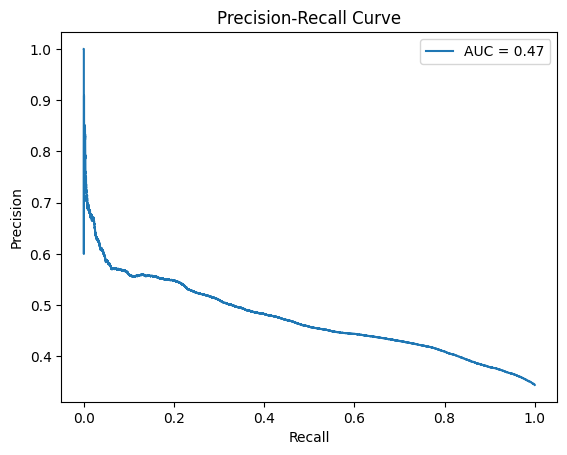

In [ ]:
from sklearn.metrics import precision_recall_curve, auc

# Get predicted probabilities for the positive class
y_pred_proba = lstm1.predict(testX_CNN)[:, 1]

# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(testY_CNN[:, 1], y_pred_proba)

# Calculate area under the curve
auc_score = auc(recall, precision)

# Plot the precision-recall curve
plt.plot(recall, precision, label=f'AUC = {auc_score:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [ ]:
print(accuracy_score(np.argmax(trainY_CNN, axis=1), np.argmax(lstm1.predict(trainX_CNN), axis=1)))

6366/6366 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step
0.672794929823614


In [ ]:
print(classification_report(np.argmax(trainY_CNN, axis=1), np.argmax(lstm1.predict(trainX_CNN), axis=1)))

6366/6366 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step
              precision    recall  f1-score   support

           0       0.64      0.78      0.71     84426
           1       0.70      0.37      0.49     36210
           2       0.70      0.69      0.70     83065

    accuracy                           0.67    203701
   macro avg       0.68      0.62      0.63    203701
weighted avg       0.68      0.67      0.66    203701



6366/6366 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step


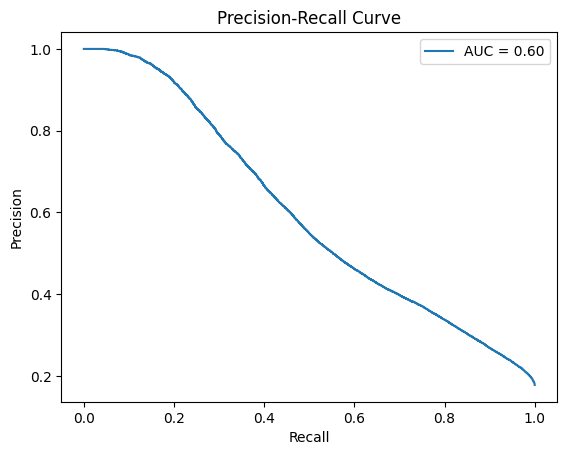

In [ ]:
from sklearn.metrics import precision_recall_curve, auc

# Get predicted probabilities for the positive class
y_pred_proba = lstm1.predict(trainX_CNN)[:, 1]

# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(trainY_CNN[:, 1], y_pred_proba)

# Calculate area under the curve
auc_score = auc(recall, precision)

# Plot the precision-recall curve
plt.plot(recall, precision, label=f'AUC = {auc_score:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [ ]:
""" TRADING STRATEGY BEFORE ATTACK ON TEST DATA"""
import numpy as np
import pandas as pd

print("Getting predictions...")
train_predictions = lstm1.predict(testX_CNN)

# First define our strategy function
def implement_fi2010_strategy(predictions, dec_data, budget=100, prob_threshold=0.8, k=4, alpha=0.002):
    # Get average ask and bid prices
    ask_prices = dec_data[0, :]
    bid_prices = dec_data[2, :]
    mid_prices = (ask_prices + bid_prices) / 2

    min_length = min(len(predictions), len(mid_prices) - k)
    predictions = predictions[:min_length]

    trades_info = []

    for i in range(k, min_length):
        m_plus = np.mean(mid_prices[i+1:i+k+1])

        lt = (m_plus - mid_prices[i]) / mid_prices[i]

        pred_class = np.argmax([predictions[i, 0], predictions[i, 1], predictions[i, 2]])
        max_prob = np.max([predictions[i, 0], predictions[i, 1], predictions[i, 2]])

        if max_prob > prob_threshold and pred_class != 1:
            actual_direction = 1 if lt > alpha else (-1 if lt < -alpha else 0)


            if pred_class == 2:
                shares = budget / mid_prices[i]
                cost = shares * mid_prices[i]
                proceeds = shares * m_plus
                profit = proceeds - cost

                trades_info.append({
                    'movement': 'up',
                    'entry_price': mid_prices[i],
                    'exit_price': m_plus,
                    'shares': shares,
                    'price_change': m_plus - mid_prices[i],
                    'price_change_pct': lt,
                    'cost': cost,
                    'proceeds': proceeds,
                    'profit': profit,
                    'prob': predictions[i, 2],
                    'correct': actual_direction == 1,
                    'index': i
                })
            elif pred_class == 0:
                shares = budget / mid_prices[i]
                proceeds = shares * mid_prices[i]
                cost = shares * m_plus
                profit = proceeds - cost

                trades_info.append({
                    'movement': 'down',
                    'entry_price': mid_prices[i],
                    'exit_price': m_plus,
                    'shares': shares,
                    'price_change': m_plus - mid_prices[i],
                    'price_change_pct': lt,
                    'cost': cost,
                    'proceeds': proceeds,
                    'profit': profit,
                    'prob': predictions[i, 0],
                    'correct': actual_direction == -1,
                    'index': i
                })

    if trades_info:
        trades_df = pd.DataFrame(trades_info)

        print("\nTrading Performance:")
        print(f"Total trades: {len(trades_df)}")
        print(f"Win rate: {(trades_df['correct'].mean() * 100):.2f}%")
        print(f"Total profit: ${trades_df['profit'].sum():.2f}")
        print(f"Average profit per trade: ${trades_df['profit'].mean():.4f}")

        print("\nDirection Analysis:")
        for direction in ['up', 'down']:
            mask = trades_df['movement'] == direction
            if mask.any():
                direction_df = trades_df[mask]
                print(f"\n{direction.upper()} trades:")
                print(f"Count: {len(direction_df)}")
                print(f"Win rate: {(direction_df['correct'].mean() * 100):.2f}%")
                print(f"Total profit: ${direction_df['profit'].sum():.2f}")
                print(f"Average profit: ${direction_df['profit'].mean():.4f}")

        return {
            'threshold': prob_threshold,
            'total_profit': trades_df['profit'].sum(),
            'num_trades': len(trades_df),
            'win_rate': trades_df['correct'].mean() * 100,
            'avg_profit': trades_df['profit'].mean(),
            'long_trades': len(trades_df[trades_df['movement'] == 'up']),
            'short_trades': len(trades_df[trades_df['movement'] == 'down'])
        }
    return None

# Test different probability thresholds
thresholds = [0.8, 0.85, 0.9, 0.95, 0.99]
results = []

print("Testing strategy with different thresholds...")
for threshold in thresholds:
    print(f"\nTesting threshold: {threshold}")
    result = implement_fi2010_strategy(
        predictions=train_predictions,
        dec_data=dec_test,
        prob_threshold=threshold,
        k=4,
        alpha=0.001
    )
    if result:
        results.append(result)

# Create summary table
if results:
    results_df = pd.DataFrame(results)
    print("\nSummary of results for different probability thresholds:")
    pd.set_option('display.float_format', lambda x: '{:.6f}'.format(x))
    print(results_df)

Getting predictions...
4359/4359 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step
Testing strategy with different thresholds...

Testing threshold: 0.8

Trading Performance:
Total trades: 19317
Win rate: 0.59%
Total profit: $341.65
Average profit per trade: $0.0177

Direction Analysis:

UP trades:
Count: 9514
Win rate: 0.62%
Total profit: $151.84
Average profit: $0.0160

DOWN trades:
Count: 9803
Win rate: 0.56%
Total profit: $189.81
Average profit: $0.0194

Testing threshold: 0.85

Trading Performance:
Total trades: 14235
Win rate: 0.65%
Total profit: $340.69
Average profit per trade: $0.0239

Direction Analysis:

UP trades:
Count: 7095
Win rate: 0.73%
Total profit: $163.49
Average profit: $0.0230

DOWN trades:
Count: 7140
Win rate: 0.57%
Total profit: $177.20
Average profit: $0.0248

Testing threshold: 0.9

Trading Performance:
Total trades: 9586
Win rate: 0.65%
Total profit: $259.27
Average profit per trade: $0.0270

Direction Analysis:

UP trades:
Count: 4850
Win rate: 0.74%
Total profit: $128.50


In [ ]:
""" TRADING STRATEGY BEFORE ATTACK ON TRAIN DATA"""
import numpy as np
import pandas as pd

print("Getting predictions...")
train_predictions = lstm1.predict(trainX_CNN)

# First define our strategy function
def implement_fi2010_strategy(predictions, dec_data, budget=100, prob_threshold=0.5, k=4, alpha=0.001):
    """
    Implements trading strategy using the FI-2010 paper's methodology

    Args:
        predictions: numpy array of model predictions (n_samples, 3)
        dec_data: numpy array of decoded price data
        budget: amount to invest per trade
        prob_threshold: probability threshold for trading
        k: prediction horizon (number of steps to look ahead)
        alpha: threshold for determining price movement direction
    """
    # Get normalized ask and bid prices
    ask_prices = dec_data[0, :]
    bid_prices = dec_data[2, :]
    mid_prices = (ask_prices + bid_prices) / 2

    min_length = min(len(predictions), len(mid_prices) - k)
    predictions = predictions[:min_length]

    trades_info = []

    for i in range(k, min_length):
        # Calculate m+ (future average) according to paper
        m_plus = np.mean(mid_prices[i+1:i+k+1])

        # Calculate actual price movement using paper's method
        lt = (m_plus - mid_prices[i]) / mid_prices[i]

        pred_class = np.argmax([predictions[i, 0], predictions[i, 1], predictions[i, 2]])
        max_prob = np.max([predictions[i, 0], predictions[i, 1], predictions[i, 2]])

        if max_prob > prob_threshold and pred_class != 1:  # not stable
            # Determine actual direction using same threshold as training
            actual_direction = 1 if lt > alpha else (-1 if lt < -alpha else 0)

            # Long trade (UP prediction)
            if pred_class == 2:
                shares = budget / mid_prices[i]
                cost = shares * mid_prices[i]
                proceeds = shares * m_plus
                profit = proceeds - cost

                trades_info.append({
                    'movement': 'up',
                    'entry_price': mid_prices[i],
                    'exit_price': m_plus,
                    'shares': shares,
                    'price_change': m_plus - mid_prices[i],
                    'price_change_pct': lt,
                    'cost': cost,
                    'proceeds': proceeds,
                    'profit': profit,
                    'prob': predictions[i, 2],
                    'correct': actual_direction == 1,
                    'index': i
                })

            # Short trade (DOWN prediction)
            elif pred_class == 0:
                shares = budget / mid_prices[i]
                proceeds = shares * mid_prices[i]
                cost = shares * m_plus
                profit = proceeds - cost

                trades_info.append({
                    'movement': 'down',
                    'entry_price': mid_prices[i],
                    'exit_price': m_plus,
                    'shares': shares,
                    'price_change': m_plus - mid_prices[i],
                    'price_change_pct': lt,
                    'cost': cost,
                    'proceeds': proceeds,
                    'profit': profit,
                    'prob': predictions[i, 0],
                    'correct': actual_direction == -1,
                    'index': i
                })

    if trades_info:
        trades_df = pd.DataFrame(trades_info)

        # Print performance metrics
        print("\nTrading Performance:")
        print(f"Total trades: {len(trades_df)}")
        print(f"Win rate: {(trades_df['correct'].mean() * 100):.2f}%")
        print(f"Total profit: ${trades_df['profit'].sum():.2f}")
        print(f"Average profit per trade: ${trades_df['profit'].mean():.4f}")

        print("\nDirection Analysis:")
        for direction in ['up', 'down']:
            mask = trades_df['movement'] == direction
            if mask.any():
                direction_df = trades_df[mask]
                print(f"\n{direction.upper()} trades:")
                print(f"Count: {len(direction_df)}")
                print(f"Win rate: {(direction_df['correct'].mean() * 100):.2f}%")
                print(f"Total profit: ${direction_df['profit'].sum():.2f}")
                print(f"Average profit: ${direction_df['profit'].mean():.4f}")

        return {
            'threshold': prob_threshold,
            'total_profit': trades_df['profit'].sum(),
            'num_trades': len(trades_df),
            'win_rate': trades_df['correct'].mean() * 100,
            'avg_profit': trades_df['profit'].mean(),
            'long_trades': len(trades_df[trades_df['movement'] == 'up']),
            'short_trades': len(trades_df[trades_df['movement'] == 'down'])
        }
    return None

# Test different probability thresholds
thresholds = [0.8, 0.85, 0.9, 0.95, 0.99]
results = []

print("Testing strategy with different thresholds...")
for threshold in thresholds:
    print(f"\nTesting threshold: {threshold}")
    result = implement_fi2010_strategy(
        predictions=train_predictions,
        dec_data=dec_train,
        prob_threshold=threshold,
        k=4,
        alpha=0.001
    )
    if result:
        results.append(result)

# Create summary table
if results:
    results_df = pd.DataFrame(results)
    print("\nSummary of results for different probability thresholds:")
    pd.set_option('display.float_format', lambda x: '{:.6f}'.format(x))
    print(results_df)

Getting predictions...
6366/6366 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step
Testing strategy with different thresholds...

Testing threshold: 0.8

Trading Performance:
Total trades: 47827
Win rate: 0.66%
Total profit: $75.34
Average profit per trade: $0.0016

Direction Analysis:

UP trades:
Count: 23666
Win rate: 0.65%
Total profit: $22.74
Average profit: $0.0010

DOWN trades:
Count: 24161
Win rate: 0.67%
Total profit: $52.60
Average profit: $0.0022

Testing threshold: 0.85

Trading Performance:
Total trades: 37397
Win rate: 0.64%
Total profit: $64.47
Average profit per trade: $0.0017

Direction Analysis:

UP trades:
Count: 18616
Win rate: 0.66%
Total profit: $18.65
Average profit: $0.0010

DOWN trades:
Count: 18781
Win rate: 0.63%
Total profit: $45.82
Average profit: $0.0024

Testing threshold: 0.9

Trading Performance:
Total trades: 26630
Win rate: 0.64%
Total profit: $46.60
Average profit per trade: $0.0017

Direction Analysis:

UP trades:
Count: 13282
Win rate: 0.62%
Total profit: $10.05
Av

In [ ]:
def calculate_perturbation_volume(original, perturbed):
    original_flat = original.reshape(original.shape[0], -1)
    perturbed_flat = perturbed.reshape(perturbed.shape[0], -1)
    perturbation = np.linalg.norm(original_flat - perturbed_flat, ord=2, axis=1)
    avg_perturbation = np.mean(perturbation)
    return avg_perturbation

In [ ]:
""" ADVERSARIAL ATTACK ON TEST DATA ON 4 EPSILON VALUES"""
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_score, recall_score, roc_curve, auc, classification_report
import matplotlib.pyplot as plt

# Define constants
max_test_size = testX_CNN.shape[0]
batch_size = 2000
num_batches = max_test_size // batch_size
epsilon_values = [0.000001, 0.00001, 0.0001, 0.001]
num_iterations = 5
step_size = 0.01

# Define your model
model = lstm1

avg_accuracies1 = {}
avg_accuracies2 = {}
perturbed_volumes1 = {}
perturbed_volumes2 = {}
# Define dictionaries to hold precision and recall
avg_precision1 = {}
avg_recall1 = {}
avg_precision2 = {}
avg_recall2 = {}
# Define dictionaries to hold ROC AUC scores
avg_roc_auc1 = {}
avg_roc_auc2 = {}


def adversarial_pattern(image, label):
    image = tf.cast(image, tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)(label, prediction)
    gradient = tape.gradient(loss, image)
    signed_grad = tf.sign(gradient)
    return signed_grad

def data_set(testX_CNN, start_idx, end_idx):
    shifted_testX_CNN = tf.concat([testX_CNN[start_idx:end_idx, 1:100, :, :], testX_CNN[start_idx:end_idx, 99:, :, :]], axis=1)
    return shifted_testX_CNN

def fgsm_attack(images, labels, epsilon):
    with tf.GradientTape() as tape:
        tape.watch(images)
        predictions = model(images)
        loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)(labels, predictions)
    gradient = tape.gradient(loss, images)
    signed_grad = tf.sign(gradient)

    signed_masked = signed_grad.numpy()
    signed_masked[:, :99, :, :] = 0
    signed_masked[:, 99:, ::2, :] = 0
    signed_masked = tf.convert_to_tensor(signed_masked, dtype=tf.float32)

    perturbed_images = images + epsilon * signed_masked
    perturbed_images = tf.clip_by_value(perturbed_images, 0, 1)
    return perturbed_images
"""
with tf.GradientTape() as tape: automatically tracks operations for gradient calculation
tape.watch(images): Explicitly tells the gradient tape to watch the images tensor for gradient calculation
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)(labels, predictions):
Calculates the loss between the true labels and the model's predictions
Uses categorical cross-entropy loss because this is a classification problem
from_logits=False indicates that the predictions are already probabilities (softmax has been applied)
gradient = tape.gradient(loss, images)
Calculates the gradient of the loss with respect to the input images
This tells us how to change the input to maximize the loss (i.e., make the model more likely to misclassify)
signed_grad = tf.sign(gradient)
Applies the sign function to the gradient to get the direction of the gradient
signed_masked[:, :99, :, :] = 0:
Sets the gradients for the first 99 time steps to zero
This ensures we only perturb the last time step (t=99), which is what the model primarily bases its prediction on
Within the last time step (t=99), this sets gradients for every other feature to zero
The ::2 slice is accessing only even indices, which likely correspond to price data in the LOB
This ensures we only perturb volume data and not price data, making the attack more realistic
signed_masked = tf.convert_to_tensor(signed_masked, dtype=tf.float32):
Converts the masked gradient signs back to a TensorFlow tensor for further operations
perturbed_images = images + epsilon * signed_masked:
Creates adversarial examples by adding the perturbation to the original images
The perturbation is the sign of the gradient scaled by epsilon
perturbed_images = tf.clip_by_value(perturbed_images, 0, 1)
Clips the perturbed values to ensure they stay within valid range [0,1]
"""
def pgd_attack(images, labels, epsilon, trainX_CNN, start_idx, end_idx):
    perturbed_images = tf.identity(images)

    for _ in range(num_iterations):
        # Gradient step
        with tf.GradientTape() as tape:
            tape.watch(perturbed_images)
            predictions = model(perturbed_images)
            loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)(labels, predictions)
        gradient = tape.gradient(loss, perturbed_images)
        signed_grad = tf.sign(gradient)

        # Apply masking to gradient
        signed_masked = signed_grad.numpy()
        signed_masked[:, :99, :, :] = 0
        signed_masked[:, 99:, ::2, :] = 0
        signed_masked = tf.convert_to_tensor(signed_masked, dtype=tf.float32)

        # Apply gradient step
        perturbed_images = perturbed_images + step_size * signed_masked

        # Step 3: Apply clipping to valid range [0,1]
        perturbed_images = tf.clip_by_value(perturbed_images, 0, 1)
        # This ensures volume constraint takes precedence if there's a conflict
        perturbed_images = volume_constraint(perturbed_images, trainX_CNN, 2, start_idx, end_idx)

    return perturbed_images


def volume_constraint(images, testX_CNN, dimension, start_idx, end_idx):
    images = images.numpy()
    slices = [slice(None)] * images.ndim
    testX_CNN = testX_CNN[start_idx:end_idx]
    for idx in range(images.shape[dimension]):
        slices[dimension] = idx
        images[tuple(slices)] = np.maximum(images[tuple(slices)], testX_CNN[tuple(slices)])
    images = tf.convert_to_tensor(images, dtype=tf.float32)
    return images

def plot_roc_curve(y_true, y_score1, y_score2, epsilon):
    """
    Plot ROC curve for both attacks at a specific epsilon value
    """
    # Get number of classes
    n_classes = y_score1.shape[1]

    # Compute ROC curve and ROC area for each class for PGD
    fpr1 = dict()
    tpr1 = dict()
    roc_auc1 = dict()
    for i in range(n_classes):
        fpr1[i], tpr1[i], _ = roc_curve(y_true[:, i], y_score1[:, i])
        roc_auc1[i] = auc(fpr1[i], tpr1[i])

    # Compute ROC curve and ROC area for each class for FGSM
    fpr2 = dict()
    tpr2 = dict()
    roc_auc2 = dict()
    for i in range(n_classes):
        fpr2[i], tpr2[i], _ = roc_curve(y_true[:, i], y_score2[:, i])
        roc_auc2[i] = auc(fpr2[i], tpr2[i])

    # Calculate macro average ROC curve and ROC area
    all_fpr1 = np.unique(np.concatenate([fpr1[i] for i in range(n_classes)]))
    all_fpr2 = np.unique(np.concatenate([fpr2[i] for i in range(n_classes)]))

    mean_tpr1 = np.zeros_like(all_fpr1)
    mean_tpr2 = np.zeros_like(all_fpr2)
    for i in range(n_classes):
        mean_tpr1 += np.interp(all_fpr1, fpr1[i], tpr1[i])
        mean_tpr2 += np.interp(all_fpr2, fpr2[i], tpr2[i])

    mean_tpr1 /= n_classes
    mean_tpr2 /= n_classes

    macro_roc_auc1 = auc(all_fpr1, mean_tpr1)
    macro_roc_auc2 = auc(all_fpr2, mean_tpr2)

    # Plot ROC curve only as per the requirement
    plt.figure(figsize=(10, 8))
    plt.plot(all_fpr1, mean_tpr1, label=f'PGD Attack - Macro-average ROC (AUC = {macro_roc_auc1:.2f})',
             color='blue', linestyle='solid', linewidth=2)
    plt.plot(all_fpr2, mean_tpr2, label=f'FGSM Attack - Macro-average ROC (AUC = {macro_roc_auc2:.2f})',
             color='red', linestyle='dashed', linewidth=2)

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for PGD and FGSM Attacks with ε = {epsilon}')
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--', alpha=0.7)

    # Save the figure
    plt.savefig(f'roc_curve_epsilon_{epsilon}.png', dpi=300, bbox_inches='tight')
    plt.close()

    return macro_roc_auc1, macro_roc_auc2

# Lists to store all prediction probabilities and true labels for ROC curves
all_true_labels_onehot = []
all_pred_probs_pgd = []
all_pred_probs_fgsm = []

for epsilon in epsilon_values:
    print(f"Epsilon value: {epsilon}")
    total_accuracy1 = 0.0
    total_accuracy2 = 0.0
    total_perturbation1 = 0.0
    total_perturbation2 = 0.0
    all_true_labels = []
    all_predicted_labels1 = []
    all_predicted_labels2 = []

    # For this epsilon, collect all prediction probabilities
    epsilon_true_labels_onehot = []
    epsilon_pred_probs_pgd = []
    epsilon_pred_probs_fgsm = []

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size

        batch_images = data_set(testX_CNN, start_idx, end_idx)
        batch_images = volume_constraint(batch_images, testX_CNN, 2, start_idx, end_idx)
        batch_labels = testY_CNN[start_idx:end_idx]

        perturbed_images1 = pgd_attack(batch_images, batch_labels, epsilon, trainX_CNN, start_idx, end_idx)
        perturbed_images2 = fgsm_attack(batch_images, batch_labels, epsilon)

        perturbation1 = calculate_perturbation_volume(batch_images.numpy(), perturbed_images1.numpy())
        perturbation2 = calculate_perturbation_volume(batch_images.numpy(), perturbed_images2.numpy())

        total_perturbation1 += perturbation1
        total_perturbation2 += perturbation2

        X_perturbed1 = perturbed_images1.numpy()
        X_perturbed2 = perturbed_images2.numpy()

        # Get raw probabilities for ROC curve
        adversarial_probs1 = model.predict(X_perturbed1)
        adversarial_probs2 = model.predict(X_perturbed2)

        # Get predicted labels
        adversarial_predictions1 = np.argmax(adversarial_probs1, axis=1)
        adversarial_predictions2 = np.argmax(adversarial_probs2, axis=1)

        # Collect data for ROC curve
        epsilon_true_labels_onehot.append(batch_labels)
        epsilon_pred_probs_pgd.append(adversarial_probs1)
        epsilon_pred_probs_fgsm.append(adversarial_probs2)

        # Append results for precision and recall calculation
        true_labels_batch = np.argmax(batch_labels, axis=1)
        all_true_labels.extend(true_labels_batch)
        all_predicted_labels1.extend(adversarial_predictions1)
        all_predicted_labels2.extend(adversarial_predictions2)

        accuracy1 = accuracy_score(true_labels_batch, adversarial_predictions1)
        accuracy2 = accuracy_score(true_labels_batch, adversarial_predictions2)
        total_accuracy1 += accuracy1
        total_accuracy2 += accuracy2

    average_accuracy1 = total_accuracy1 / num_batches
    average_accuracy2 = total_accuracy2 / num_batches
    avg_perturbation1 = total_perturbation1 / num_batches
    avg_perturbation2 = total_perturbation2 / num_batches

    # Concatenate all batches for this epsilon
    epsilon_true_labels_onehot = np.vstack(epsilon_true_labels_onehot)
    epsilon_pred_probs_pgd = np.vstack(epsilon_pred_probs_pgd)
    epsilon_pred_probs_fgsm = np.vstack(epsilon_pred_probs_fgsm)

    # Calculate and plot ROC curve
    roc_auc1, roc_auc2 = plot_roc_curve(
        epsilon_true_labels_onehot,
        epsilon_pred_probs_pgd,
        epsilon_pred_probs_fgsm,
        epsilon
    )

    avg_roc_auc1[epsilon] = roc_auc1
    avg_roc_auc2[epsilon] = roc_auc2

    # Calculate precision and recall
    precision1 = precision_score(all_true_labels, all_predicted_labels1, average='macro')
    recall1 = recall_score(all_true_labels, all_predicted_labels1, average='macro')
    precision2 = precision_score(all_true_labels, all_predicted_labels2, average='macro')
    recall2 = recall_score(all_true_labels, all_predicted_labels2, average='macro')

    avg_precision1[epsilon] = precision1
    avg_recall1[epsilon] = recall1
    avg_precision2[epsilon] = precision2
    avg_recall2[epsilon] = recall2

    # Generate classification reports
    pgd_report = classification_report(all_true_labels, all_predicted_labels1, output_dict=True)
    fgsm_report = classification_report(all_true_labels, all_predicted_labels2, output_dict=True)

    print(f"Average accuracy of PGD attack for epsilon value {epsilon}: {average_accuracy1}")
    avg_accuracies1[epsilon] = average_accuracy1
    print(f"Average accuracy of FGSM attack for epsilon value {epsilon}: {average_accuracy2}")
    avg_accuracies2[epsilon] = average_accuracy2
    print(f"Average perturbation volume for PGD attack with epsilon {epsilon}: {avg_perturbation1}")
    perturbed_volumes1[epsilon] = avg_perturbation1
    print(f"Average perturbation volume for FGSM attack with epsilon {epsilon}: {avg_perturbation2}")
    perturbed_volumes2[epsilon] = avg_perturbation2

    # Print precision and recall
    print(f"Average precision of PGD attack for epsilon value {epsilon}: {precision1}")
    print(f"Average recall of PGD attack for epsilon value {epsilon}: {recall1}")
    print(f"Average precision of FGSM attack for epsilon value {epsilon}: {precision2}")
    print(f"Average recall of FGSM attack for epsilon value {epsilon}: {recall2}")

    # Print ROC AUC
    print(f"ROC AUC of PGD attack for epsilon value {epsilon}: {roc_auc1}")
    print(f"ROC AUC of FGSM attack for epsilon value {epsilon}: {roc_auc2}")

    # Print classification reports
    print(f"\nClassification Report for PGD Attack (ε = {epsilon}):")
    print(classification_report(all_true_labels, all_predicted_labels1))

    print(f"\nClassification Report for FGSM Attack (ε = {epsilon}):")
    print(classification_report(all_true_labels, all_predicted_labels2))

    # Clean up
    tf.keras.backend.clear_session()

Epsilon value: 1e-06
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/6

In [ ]:
""" ADVERSARIAL ATTACK ON TEST DATA ON 1 EPSILON VALUES"""
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_score, recall_score, roc_curve, auc, classification_report
import matplotlib.pyplot as plt

# Define constants
max_test_size = testX_CNN.shape[0]
batch_size = 2000
num_batches = max_test_size // batch_size
epsilon_values = [0.01]
num_iterations = 5
step_size = 0.01

# Define your model
model = lstm1

avg_accuracies1 = {}
avg_accuracies2 = {}
perturbed_volumes1 = {}
perturbed_volumes2 = {}
# Define dictionaries to hold precision and recall
avg_precision1 = {}
avg_recall1 = {}
avg_precision2 = {}
avg_recall2 = {}
# Define dictionaries to hold ROC AUC scores
avg_roc_auc1 = {}
avg_roc_auc2 = {}


def adversarial_pattern(image, label):
    image = tf.cast(image, tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)(label, prediction)
    gradient = tape.gradient(loss, image)
    signed_grad = tf.sign(gradient)
    return signed_grad

def data_set(testX_CNN, start_idx, end_idx):
    shifted_testX_CNN = tf.concat([testX_CNN[start_idx:end_idx, 1:100, :, :], testX_CNN[start_idx:end_idx, 99:, :, :]], axis=1)
    return shifted_testX_CNN

def fgsm_attack(images, labels, epsilon):
    with tf.GradientTape() as tape:
        tape.watch(images)
        predictions = model(images)
        loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)(labels, predictions)
    gradient = tape.gradient(loss, images)
    signed_grad = tf.sign(gradient)

    signed_masked = signed_grad.numpy()
    signed_masked[:, :99, :, :] = 0
    signed_masked[:, 99:, ::2, :] = 0
    signed_masked = tf.convert_to_tensor(signed_masked, dtype=tf.float32)

    perturbed_images = images + epsilon * signed_masked
    perturbed_images = tf.clip_by_value(perturbed_images, 0, 1)
    return perturbed_images

def pgd_attack(images, labels, epsilon, trainX_CNN, start_idx, end_idx):
    perturbed_images = tf.identity(images)

    for _ in range(num_iterations):
        # Gradient step
        with tf.GradientTape() as tape:
            tape.watch(perturbed_images)
            predictions = model(perturbed_images)
            loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)(labels, predictions)
        gradient = tape.gradient(loss, perturbed_images)
        signed_grad = tf.sign(gradient)

        # Apply masking to gradient
        signed_masked = signed_grad.numpy()
        signed_masked[:, :99, :, :] = 0
        signed_masked[:, 99:, ::2, :] = 0
        signed_masked = tf.convert_to_tensor(signed_masked, dtype=tf.float32)

        # Apply gradient step
        perturbed_images = perturbed_images + step_size * signed_masked

        # Apply volume constraint
        perturbed_images = volume_constraint(perturbed_images, trainX_CNN, 2, start_idx, end_idx)

    return perturbed_images

def volume_constraint(images, testX_CNN, dimension, start_idx, end_idx):
    images = images.numpy()
    slices = [slice(None)] * images.ndim
    testX_CNN = testX_CNN[start_idx:end_idx]
    for idx in range(images.shape[dimension]):
        slices[dimension] = idx
        images[tuple(slices)] = np.maximum(images[tuple(slices)], testX_CNN[tuple(slices)])
    images = tf.convert_to_tensor(images, dtype=tf.float32)
    return images

def plot_roc_curve(y_true, y_score1, y_score2, epsilon):
    """
    Plot ROC curve for both attacks at a specific epsilon value
    """
    # Get number of classes
    n_classes = y_score1.shape[1]

    # Compute ROC curve and ROC area for each class for PGD
    fpr1 = dict()
    tpr1 = dict()
    roc_auc1 = dict()
    for i in range(n_classes):
        fpr1[i], tpr1[i], _ = roc_curve(y_true[:, i], y_score1[:, i])
        roc_auc1[i] = auc(fpr1[i], tpr1[i])

    # Compute ROC curve and ROC area for each class for FGSM
    fpr2 = dict()
    tpr2 = dict()
    roc_auc2 = dict()
    for i in range(n_classes):
        fpr2[i], tpr2[i], _ = roc_curve(y_true[:, i], y_score2[:, i])
        roc_auc2[i] = auc(fpr2[i], tpr2[i])

    # Calculate macro average ROC curve and ROC area
    all_fpr1 = np.unique(np.concatenate([fpr1[i] for i in range(n_classes)]))
    all_fpr2 = np.unique(np.concatenate([fpr2[i] for i in range(n_classes)]))

    mean_tpr1 = np.zeros_like(all_fpr1)
    mean_tpr2 = np.zeros_like(all_fpr2)
    for i in range(n_classes):
        mean_tpr1 += np.interp(all_fpr1, fpr1[i], tpr1[i])
        mean_tpr2 += np.interp(all_fpr2, fpr2[i], tpr2[i])

    mean_tpr1 /= n_classes
    mean_tpr2 /= n_classes

    macro_roc_auc1 = auc(all_fpr1, mean_tpr1)
    macro_roc_auc2 = auc(all_fpr2, mean_tpr2)

    # Plot ROC curve only as per the requirement
    plt.figure(figsize=(10, 8))
    plt.plot(all_fpr1, mean_tpr1, label=f'PGD Attack - Macro-average ROC (AUC = {macro_roc_auc1:.2f})',
             color='blue', linestyle='solid', linewidth=2)
    plt.plot(all_fpr2, mean_tpr2, label=f'FGSM Attack - Macro-average ROC (AUC = {macro_roc_auc2:.2f})',
             color='red', linestyle='dashed', linewidth=2)

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for PGD and FGSM Attacks with ε = {epsilon}')
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--', alpha=0.7)

    # Save the figure
    plt.savefig(f'roc_curve_epsilon_{epsilon}.png', dpi=300, bbox_inches='tight')
    plt.close()

    return macro_roc_auc1, macro_roc_auc2

# Lists to store all prediction probabilities and true labels for ROC curves
all_true_labels_onehot = []
all_pred_probs_pgd = []
all_pred_probs_fgsm = []

for epsilon in epsilon_values:
    print(f"Epsilon value: {epsilon}")
    total_accuracy1 = 0.0
    total_accuracy2 = 0.0
    total_perturbation1 = 0.0
    total_perturbation2 = 0.0
    all_true_labels = []
    all_predicted_labels1 = []
    all_predicted_labels2 = []

    # For this epsilon, collect all prediction probabilities
    epsilon_true_labels_onehot = []
    epsilon_pred_probs_pgd = []
    epsilon_pred_probs_fgsm = []

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size

        batch_images = data_set(testX_CNN, start_idx, end_idx)
        batch_images = volume_constraint(batch_images, testX_CNN, 2, start_idx, end_idx)
        batch_labels = testY_CNN[start_idx:end_idx]

        perturbed_images1 = pgd_attack(batch_images, batch_labels, epsilon, trainX_CNN, start_idx, end_idx)
        perturbed_images2 = fgsm_attack(batch_images, batch_labels, epsilon)

        perturbation1 = calculate_perturbation_volume(batch_images.numpy(), perturbed_images1.numpy())
        perturbation2 = calculate_perturbation_volume(batch_images.numpy(), perturbed_images2.numpy())

        total_perturbation1 += perturbation1
        total_perturbation2 += perturbation2

        X_perturbed1 = perturbed_images1.numpy()
        X_perturbed2 = perturbed_images2.numpy()

        # Get raw probabilities for ROC curve
        adversarial_probs1 = model.predict(X_perturbed1)
        adversarial_probs2 = model.predict(X_perturbed2)

        # Get predicted labels
        adversarial_predictions1 = np.argmax(adversarial_probs1, axis=1)
        adversarial_predictions2 = np.argmax(adversarial_probs2, axis=1)

        # Collect data for ROC curve
        epsilon_true_labels_onehot.append(batch_labels)
        epsilon_pred_probs_pgd.append(adversarial_probs1)
        epsilon_pred_probs_fgsm.append(adversarial_probs2)

        # Append results for precision and recall calculation
        true_labels_batch = np.argmax(batch_labels, axis=1)
        all_true_labels.extend(true_labels_batch)
        all_predicted_labels1.extend(adversarial_predictions1)
        all_predicted_labels2.extend(adversarial_predictions2)

        accuracy1 = accuracy_score(true_labels_batch, adversarial_predictions1)
        accuracy2 = accuracy_score(true_labels_batch, adversarial_predictions2)
        total_accuracy1 += accuracy1
        total_accuracy2 += accuracy2

    average_accuracy1 = total_accuracy1 / num_batches
    average_accuracy2 = total_accuracy2 / num_batches
    avg_perturbation1 = total_perturbation1 / num_batches
    avg_perturbation2 = total_perturbation2 / num_batches

    # Concatenate all batches for this epsilon
    epsilon_true_labels_onehot = np.vstack(epsilon_true_labels_onehot)
    epsilon_pred_probs_pgd = np.vstack(epsilon_pred_probs_pgd)
    epsilon_pred_probs_fgsm = np.vstack(epsilon_pred_probs_fgsm)

    # Calculate and plot ROC curve
    roc_auc1, roc_auc2 = plot_roc_curve(
        epsilon_true_labels_onehot,
        epsilon_pred_probs_pgd,
        epsilon_pred_probs_fgsm,
        epsilon
    )

    avg_roc_auc1[epsilon] = roc_auc1
    avg_roc_auc2[epsilon] = roc_auc2

    # Calculate precision and recall
    precision1 = precision_score(all_true_labels, all_predicted_labels1, average='macro')
    recall1 = recall_score(all_true_labels, all_predicted_labels1, average='macro')
    precision2 = precision_score(all_true_labels, all_predicted_labels2, average='macro')
    recall2 = recall_score(all_true_labels, all_predicted_labels2, average='macro')

    avg_precision1[epsilon] = precision1
    avg_recall1[epsilon] = recall1
    avg_precision2[epsilon] = precision2
    avg_recall2[epsilon] = recall2

    # Generate classification reports
    pgd_report = classification_report(all_true_labels, all_predicted_labels1, output_dict=True)
    fgsm_report = classification_report(all_true_labels, all_predicted_labels2, output_dict=True)

    print(f"Average accuracy of PGD attack for epsilon value {epsilon}: {average_accuracy1}")
    avg_accuracies1[epsilon] = average_accuracy1
    print(f"Average accuracy of FGSM attack for epsilon value {epsilon}: {average_accuracy2}")
    avg_accuracies2[epsilon] = average_accuracy2
    print(f"Average perturbation volume for PGD attack with epsilon {epsilon}: {avg_perturbation1}")
    perturbed_volumes1[epsilon] = avg_perturbation1
    print(f"Average perturbation volume for FGSM attack with epsilon {epsilon}: {avg_perturbation2}")
    perturbed_volumes2[epsilon] = avg_perturbation2

    # Print precision and recall
    print(f"Average precision of PGD attack for epsilon value {epsilon}: {precision1}")
    print(f"Average recall of PGD attack for epsilon value {epsilon}: {recall1}")
    print(f"Average precision of FGSM attack for epsilon value {epsilon}: {precision2}")
    print(f"Average recall of FGSM attack for epsilon value {epsilon}: {recall2}")

    # Print ROC AUC
    print(f"ROC AUC of PGD attack for epsilon value {epsilon}: {roc_auc1}")
    print(f"ROC AUC of FGSM attack for epsilon value {epsilon}: {roc_auc2}")

    # Print classification reports
    print(f"\nClassification Report for PGD Attack (ε = {epsilon}):")
    print(classification_report(all_true_labels, all_predicted_labels1))

    print(f"\nClassification Report for FGSM Attack (ε = {epsilon}):")
    print(classification_report(all_true_labels, all_predicted_labels2))

    # Clean up
    tf.keras.backend.clear_session()

Epsilon value: 0.01
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
63/63

In [ ]:
""" ADVERSARIAL ATTACK ON TEST DATA ON 3 EPSILON VALUES"""
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_score, recall_score, roc_curve, auc, classification_report
import matplotlib.pyplot as plt

# Define constants
max_test_size = testX_CNN.shape[0]
batch_size = 2000
num_batches = max_test_size // batch_size
epsilon_values = [0.1, 1, 10]
num_iterations = 5
step_size = 0.01

# Define your model
model = lstm1

avg_accuracies1 = {}
avg_accuracies2 = {}
perturbed_volumes1 = {}
perturbed_volumes2 = {}
# Define dictionaries to hold precision and recall
avg_precision1 = {}
avg_recall1 = {}
avg_precision2 = {}
avg_recall2 = {}
# Define dictionaries to hold ROC AUC scores
avg_roc_auc1 = {}
avg_roc_auc2 = {}


def adversarial_pattern(image, label):
    image = tf.cast(image, tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)(label, prediction)
    gradient = tape.gradient(loss, image)
    signed_grad = tf.sign(gradient)
    return signed_grad

def data_set(testX_CNN, start_idx, end_idx):
    shifted_testX_CNN = tf.concat([testX_CNN[start_idx:end_idx, 1:100, :, :], testX_CNN[start_idx:end_idx, 99:, :, :]], axis=1)
    return shifted_testX_CNN

def fgsm_attack(images, labels, epsilon):
    with tf.GradientTape() as tape:
        tape.watch(images)
        predictions = model(images)
        loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)(labels, predictions)
    gradient = tape.gradient(loss, images)
    signed_grad = tf.sign(gradient)

    signed_masked = signed_grad.numpy()
    signed_masked[:, :99, :, :] = 0
    signed_masked[:, 99:, ::2, :] = 0
    signed_masked = tf.convert_to_tensor(signed_masked, dtype=tf.float32)

    perturbed_images = images + epsilon * signed_masked
    perturbed_images = tf.clip_by_value(perturbed_images, 0, 1)
    return perturbed_images

def pgd_attack(images, labels, epsilon, trainX_CNN, start_idx, end_idx):
    perturbed_images = tf.identity(images)

    for _ in range(num_iterations):
        # Gradient step
        with tf.GradientTape() as tape:
            tape.watch(perturbed_images)
            predictions = model(perturbed_images)
            loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)(labels, predictions)
        gradient = tape.gradient(loss, perturbed_images)
        signed_grad = tf.sign(gradient)

        # Apply masking to gradient
        signed_masked = signed_grad.numpy()
        signed_masked[:, :99, :, :] = 0
        signed_masked[:, 99:, ::2, :] = 0
        signed_masked = tf.convert_to_tensor(signed_masked, dtype=tf.float32)

        # Apply gradient step
        perturbed_images = perturbed_images + step_size * signed_masked

        # Step 1: Apply volume constraint
        perturbed_images = volume_constraint(perturbed_images, trainX_CNN, 2, start_idx, end_idx)

        # Step 2: Apply L2 norm constraint (projection step)
        delta = perturbed_images - images  # Calculate current perturbation

        # Reshape to flatten all dimensions except batch
        delta_flat = tf.reshape(delta, [tf.shape(delta)[0], -1])

        # Calculate L2 norm on the flattened dimensions
        norm = tf.norm(delta_flat, axis=1, keepdims=True)

        # Reshape norm for broadcasting
        norm = tf.reshape(norm, [tf.shape(delta)[0], 1, 1, 1])

        # Scale perturbation
        scaling = tf.clip_by_value(epsilon / (norm + 1e-12), 0, 1)
        delta = delta * scaling

        perturbed_images = images + delta  # Apply constrained perturbation

        # Step 3: Apply clipping to valid range [0,1]
        perturbed_images = tf.clip_by_value(perturbed_images, 0, 1)

        # Step 4: Re-apply volume constraint after all other constraints
        # This ensures volume constraint takes precedence if there's a conflict
        perturbed_images = volume_constraint(perturbed_images, trainX_CNN, 2, start_idx, end_idx)

    return perturbed_images

def volume_constraint(images, testX_CNN, dimension, start_idx, end_idx):
    images = images.numpy()
    slices = [slice(None)] * images.ndim
    testX_CNN = testX_CNN[start_idx:end_idx]
    for idx in range(images.shape[dimension]):
        slices[dimension] = idx
        images[tuple(slices)] = np.maximum(images[tuple(slices)], testX_CNN[tuple(slices)])
    images = tf.convert_to_tensor(images, dtype=tf.float32)
    return images

def plot_roc_curve(y_true, y_score1, y_score2, epsilon):
    """
    Plot ROC curve for both attacks at a specific epsilon value
    """
    # Get number of classes
    n_classes = y_score1.shape[1]

    # Compute ROC curve and ROC area for each class for PGD
    fpr1 = dict()
    tpr1 = dict()
    roc_auc1 = dict()
    for i in range(n_classes):
        fpr1[i], tpr1[i], _ = roc_curve(y_true[:, i], y_score1[:, i])
        roc_auc1[i] = auc(fpr1[i], tpr1[i])

    # Compute ROC curve and ROC area for each class for FGSM
    fpr2 = dict()
    tpr2 = dict()
    roc_auc2 = dict()
    for i in range(n_classes):
        fpr2[i], tpr2[i], _ = roc_curve(y_true[:, i], y_score2[:, i])
        roc_auc2[i] = auc(fpr2[i], tpr2[i])

    # Calculate macro average ROC curve and ROC area
    all_fpr1 = np.unique(np.concatenate([fpr1[i] for i in range(n_classes)]))
    all_fpr2 = np.unique(np.concatenate([fpr2[i] for i in range(n_classes)]))

    mean_tpr1 = np.zeros_like(all_fpr1)
    mean_tpr2 = np.zeros_like(all_fpr2)
    for i in range(n_classes):
        mean_tpr1 += np.interp(all_fpr1, fpr1[i], tpr1[i])
        mean_tpr2 += np.interp(all_fpr2, fpr2[i], tpr2[i])

    mean_tpr1 /= n_classes
    mean_tpr2 /= n_classes

    macro_roc_auc1 = auc(all_fpr1, mean_tpr1)
    macro_roc_auc2 = auc(all_fpr2, mean_tpr2)

    # Plot ROC curve only as per the requirement
    plt.figure(figsize=(10, 8))
    plt.plot(all_fpr1, mean_tpr1, label=f'PGD Attack - Macro-average ROC (AUC = {macro_roc_auc1:.2f})',
             color='blue', linestyle='solid', linewidth=2)
    plt.plot(all_fpr2, mean_tpr2, label=f'FGSM Attack - Macro-average ROC (AUC = {macro_roc_auc2:.2f})',
             color='red', linestyle='dashed', linewidth=2)

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for PGD and FGSM Attacks with ε = {epsilon}')
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--', alpha=0.7)

    # Save the figure
    plt.savefig(f'roc_curve_epsilon_{epsilon}.png', dpi=300, bbox_inches='tight')
    plt.close()

    return macro_roc_auc1, macro_roc_auc2

# Lists to store all prediction probabilities and true labels for ROC curves
all_true_labels_onehot = []
all_pred_probs_pgd = []
all_pred_probs_fgsm = []

for epsilon in epsilon_values:
    print(f"Epsilon value: {epsilon}")
    total_accuracy1 = 0.0
    total_accuracy2 = 0.0
    total_perturbation1 = 0.0
    total_perturbation2 = 0.0
    all_true_labels = []
    all_predicted_labels1 = []
    all_predicted_labels2 = []

    # For this epsilon, collect all prediction probabilities
    epsilon_true_labels_onehot = []
    epsilon_pred_probs_pgd = []
    epsilon_pred_probs_fgsm = []

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size

        batch_images = data_set(testX_CNN, start_idx, end_idx)
        batch_images = volume_constraint(batch_images, testX_CNN, 2, start_idx, end_idx)
        batch_labels = testY_CNN[start_idx:end_idx]

        perturbed_images1 = pgd_attack(batch_images, batch_labels, epsilon, trainX_CNN, start_idx, end_idx)
        perturbed_images2 = fgsm_attack(batch_images, batch_labels, epsilon)

        perturbation1 = calculate_perturbation_volume(batch_images.numpy(), perturbed_images1.numpy())
        perturbation2 = calculate_perturbation_volume(batch_images.numpy(), perturbed_images2.numpy())

        total_perturbation1 += perturbation1
        total_perturbation2 += perturbation2

        X_perturbed1 = perturbed_images1.numpy()
        X_perturbed2 = perturbed_images2.numpy()

        # Get raw probabilities for ROC curve
        adversarial_probs1 = model.predict(X_perturbed1)
        adversarial_probs2 = model.predict(X_perturbed2)

        # Get predicted labels
        adversarial_predictions1 = np.argmax(adversarial_probs1, axis=1)
        adversarial_predictions2 = np.argmax(adversarial_probs2, axis=1)

        # Collect data for ROC curve
        epsilon_true_labels_onehot.append(batch_labels)
        epsilon_pred_probs_pgd.append(adversarial_probs1)
        epsilon_pred_probs_fgsm.append(adversarial_probs2)

        # Append results for precision and recall calculation
        true_labels_batch = np.argmax(batch_labels, axis=1)
        all_true_labels.extend(true_labels_batch)
        all_predicted_labels1.extend(adversarial_predictions1)
        all_predicted_labels2.extend(adversarial_predictions2)

        accuracy1 = accuracy_score(true_labels_batch, adversarial_predictions1)
        accuracy2 = accuracy_score(true_labels_batch, adversarial_predictions2)
        total_accuracy1 += accuracy1
        total_accuracy2 += accuracy2

    average_accuracy1 = total_accuracy1 / num_batches
    average_accuracy2 = total_accuracy2 / num_batches
    avg_perturbation1 = total_perturbation1 / num_batches
    avg_perturbation2 = total_perturbation2 / num_batches

    # Concatenate all batches for this epsilon
    epsilon_true_labels_onehot = np.vstack(epsilon_true_labels_onehot)
    epsilon_pred_probs_pgd = np.vstack(epsilon_pred_probs_pgd)
    epsilon_pred_probs_fgsm = np.vstack(epsilon_pred_probs_fgsm)

    # Calculate and plot ROC curve
    roc_auc1, roc_auc2 = plot_roc_curve(
        epsilon_true_labels_onehot,
        epsilon_pred_probs_pgd,
        epsilon_pred_probs_fgsm,
        epsilon
    )

    avg_roc_auc1[epsilon] = roc_auc1
    avg_roc_auc2[epsilon] = roc_auc2

    # Calculate precision and recall
    precision1 = precision_score(all_true_labels, all_predicted_labels1, average='macro')
    recall1 = recall_score(all_true_labels, all_predicted_labels1, average='macro')
    precision2 = precision_score(all_true_labels, all_predicted_labels2, average='macro')
    recall2 = recall_score(all_true_labels, all_predicted_labels2, average='macro')

    avg_precision1[epsilon] = precision1
    avg_recall1[epsilon] = recall1
    avg_precision2[epsilon] = precision2
    avg_recall2[epsilon] = recall2

    # Generate classification reports
    pgd_report = classification_report(all_true_labels, all_predicted_labels1, output_dict=True)
    fgsm_report = classification_report(all_true_labels, all_predicted_labels2, output_dict=True)

    print(f"Average accuracy of PGD attack for epsilon value {epsilon}: {average_accuracy1}")
    avg_accuracies1[epsilon] = average_accuracy1
    print(f"Average accuracy of FGSM attack for epsilon value {epsilon}: {average_accuracy2}")
    avg_accuracies2[epsilon] = average_accuracy2
    print(f"Average perturbation volume for PGD attack with epsilon {epsilon}: {avg_perturbation1}")
    perturbed_volumes1[epsilon] = avg_perturbation1
    print(f"Average perturbation volume for FGSM attack with epsilon {epsilon}: {avg_perturbation2}")
    perturbed_volumes2[epsilon] = avg_perturbation2

    # Print precision and recall
    print(f"Average precision of PGD attack for epsilon value {epsilon}: {precision1}")
    print(f"Average recall of PGD attack for epsilon value {epsilon}: {recall1}")
    print(f"Average precision of FGSM attack for epsilon value {epsilon}: {precision2}")
    print(f"Average recall of FGSM attack for epsilon value {epsilon}: {recall2}")

    # Print ROC AUC
    print(f"ROC AUC of PGD attack for epsilon value {epsilon}: {roc_auc1}")
    print(f"ROC AUC of FGSM attack for epsilon value {epsilon}: {roc_auc2}")

    # Print classification reports
    print(f"\nClassification Report for PGD Attack (ε = {epsilon}):")
    print(classification_report(all_true_labels, all_predicted_labels1))

    print(f"\nClassification Report for FGSM Attack (ε = {epsilon}):")
    print(classification_report(all_true_labels, all_predicted_labels2))

    # Clean up
    tf.keras.backend.clear_session()

Epsilon value: 0.1
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
63/63 

In [ ]:
"""TRADING STRATEGY AFTER ATTACK ON 4 EPSILON VALUES"""
import numpy as np
import pandas as pd
import tensorflow as tf

def run_adversarial_trading_analysis(model, testX_CNN, testY_CNN, dec_test, epsilon_values, batch_size=2000):
    """Run trading strategy analysis with adversarial attacks"""
    results_pgd = []
    results_fgsm = []
    thresholds = [0.85, 0.90, 0.95, 0.99]  # Explicit thresholds

    # Define constants needed for PGD attack
    num_iterations = 5
    step_size = 0.01

    def data_set(testX_CNN, start_idx, end_idx):
        """Prepare the dataset by shifting"""
        shifted_testX_CNN = tf.concat([
            testX_CNN[start_idx:end_idx, 1:100, :, :],
            testX_CNN[start_idx:end_idx, 99:, :, :]
        ], axis=1)
        return tf.cast(shifted_testX_CNN, tf.float32)

    def volume_constraint(images, testX_CNN, dimension, start_idx, end_idx):
        """Apply volume constraints to the images"""
        images = images.numpy()
        slices = [slice(None)] * images.ndim
        testX_CNN_batch = testX_CNN[start_idx:end_idx]
        for idx in range(images.shape[dimension]):
            slices[dimension] = idx
            images[tuple(slices)] = np.maximum(
                images[tuple(slices)],
                testX_CNN_batch[tuple(slices)]
            )
        return tf.convert_to_tensor(images, dtype=tf.float32)

    def get_model_predictions(perturbed_images):
        """Get model predictions with error handling"""
        try:
            with tf.device('/CPU:0'):
                predictions = model(perturbed_images, training=False)
                return predictions.numpy()
        except Exception as e:
            print(f"Error in model prediction: {str(e)}")
            return None

    def fgsm_attack(images, labels, epsilon):
        """Implement FGSM attack"""
        try:
            with tf.GradientTape() as tape:
                tape.watch(images)
                predictions = model(images, training=False)
                loss = tf.keras.losses.CategoricalCrossentropy()(labels, predictions)

            gradient = tape.gradient(loss, images)
            signed_grad = tf.sign(gradient)

            signed_masked = signed_grad.numpy()
            signed_masked[:, :99, :, :] = 0
            signed_masked[:, 99:, ::2, :] = 0
            signed_masked = tf.convert_to_tensor(signed_masked, dtype=tf.float32)

            perturbed_images = images + epsilon * signed_masked
            return tf.clip_by_value(perturbed_images, 0, 1)
        except Exception as e:
            print(f"Error in FGSM attack: {str(e)}")
            return None

    def pgd_attack(images, labels, epsilon, test_data, start_idx, end_idx):
        """Implement PGD attack with volume constraint"""
        perturbed_images = tf.identity(images)

        for _ in range(num_iterations):
            # Gradient step
            with tf.GradientTape() as tape:
                tape.watch(perturbed_images)
                predictions = model(perturbed_images, training=False)
                loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)(labels, predictions)
            gradient = tape.gradient(loss, perturbed_images)
            signed_grad = tf.sign(gradient)

            # Apply masking to gradient
            signed_masked = signed_grad.numpy()
            signed_masked[:, :99, :, :] = 0
            signed_masked[:, 99:, ::2, :] = 0
            signed_masked = tf.convert_to_tensor(signed_masked, dtype=tf.float32)

            # Apply gradient step
            perturbed_images = perturbed_images + step_size * signed_masked

            # Step 1: Apply volume constraint
            perturbed_images = volume_constraint(perturbed_images, test_data, 2, start_idx, end_idx)

            # Step 2: Apply L2 norm constraint (projection step)
            delta = perturbed_images - images  # Calculate current perturbation

            # Reshape to flatten all dimensions except batch
            delta_flat = tf.reshape(delta, [tf.shape(delta)[0], -1])

            # Calculate L2 norm on the flattened dimensions
            norm = tf.norm(delta_flat, axis=1, keepdims=True)

            # Reshape norm for broadcasting
            norm = tf.reshape(norm, [tf.shape(delta)[0], 1, 1, 1])

            # Scale perturbation
            scaling = tf.clip_by_value(epsilon / (norm + 1e-12), 0, 1)
            delta = delta * scaling

            perturbed_images = images + delta  # Apply constrained perturbation

            # Step 3: Apply clipping to valid range [0,1]
            perturbed_images = tf.clip_by_value(perturbed_images, 0, 1)

            # Step 4: Re-apply volume constraint after all other constraints
            # This ensures volume constraint takes precedence if there's a conflict
            perturbed_images = volume_constraint(perturbed_images, test_data, 2, start_idx, end_idx)

        return perturbed_images

    max_test_size = testX_CNN.shape[0]
    num_batches = max_test_size // batch_size

    for epsilon in epsilon_values:
        print(f"\nAnalyzing epsilon: {epsilon}")

        pgd_predictions = []
        fgsm_predictions = []

        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, max_test_size)

            try:
                # Prepare batch data
                batch_images = data_set(testX_CNN, start_idx, end_idx)
                batch_images = volume_constraint(batch_images, testX_CNN, 2, start_idx, end_idx)
                batch_labels = testY_CNN[start_idx:end_idx]

                # Generate adversarial examples
                perturbed_images_pgd = pgd_attack(batch_images, batch_labels, epsilon, testX_CNN, start_idx, end_idx)
                perturbed_images_fgsm = fgsm_attack(batch_images, batch_labels, epsilon)

                if perturbed_images_pgd is not None and perturbed_images_fgsm is not None:
                    # Calculate perturbation volumes
                    pgd_volume = np.mean(np.linalg.norm(
                        (perturbed_images_pgd - batch_images).numpy().reshape(batch_images.shape[0], -1),
                        axis=1
                    ))
                    fgsm_volume = np.mean(np.linalg.norm(
                        (perturbed_images_fgsm - batch_images).numpy().reshape(batch_images.shape[0], -1),
                        axis=1
                    ))
                    print(f"Batch {i+1}/{num_batches} - PGD volume: {pgd_volume:.6f}, FGSM volume: {fgsm_volume:.6f}")

                    # Get predictions
                    pgd_pred = get_model_predictions(perturbed_images_pgd)
                    fgsm_pred = get_model_predictions(perturbed_images_fgsm)

                    if pgd_pred is not None:
                        pgd_predictions.append(pgd_pred)
                    if fgsm_pred is not None:
                        fgsm_predictions.append(fgsm_pred)

            except Exception as e:
                print(f"Error processing batch {i}: {str(e)}")
                continue

            tf.keras.backend.clear_session()

        if pgd_predictions and fgsm_predictions:
            pgd_predictions = np.vstack(pgd_predictions)
            fgsm_predictions = np.vstack(fgsm_predictions)

            # Process for each threshold
            for threshold in thresholds:
                # Process PGD results
                pgd_result = implement_fi2010_strategy(
                    predictions=pgd_predictions,
                    dec_data=dec_test,
                    prob_threshold=threshold
                )
                if pgd_result:
                    pgd_result.update({
                        'epsilon': epsilon,
                        'threshold': threshold,
                        'attack_type': 'PGD'
                    })
                    results_pgd.append(pgd_result)

                # Process FGSM results
                fgsm_result = implement_fi2010_strategy(
                    predictions=fgsm_predictions,
                    dec_data=dec_test,
                    prob_threshold=threshold
                )
                if fgsm_result:
                    fgsm_result.update({
                        'epsilon': epsilon,
                        'threshold': threshold,
                        'attack_type': 'FGSM'
                    })
                    results_fgsm.append(fgsm_result)

    # Create DataFrames
    pgd_df = pd.DataFrame(results_pgd) if results_pgd else pd.DataFrame()
    fgsm_df = pd.DataFrame(results_fgsm) if results_fgsm else pd.DataFrame()

    # Display detailed summaries
    if not pgd_df.empty:
        print("\nPGD Attack Summary by Threshold:")
        summary_pgd = pgd_df.groupby(['epsilon', 'threshold'])[
            ['total_profit', 'num_trades', 'win_rate']
        ].mean().round(4)

        # Format the display
        pd.set_option('display.float_format', lambda x: '%.4f' % x)
        print("\nPGD Analysis Results:")
        for eps in epsilon_values:
            print(f"\nEpsilon: {eps}")
            print(summary_pgd.loc[eps])

    if not fgsm_df.empty:
        print("\nFGSM Attack Summary by Threshold:")
        summary_fgsm = fgsm_df.groupby(['epsilon', 'threshold'])[
            ['total_profit', 'num_trades', 'win_rate']
        ].mean().round(4)

        print("\nFGSM Analysis Results:")
        for eps in epsilon_values:
            print(f"\nEpsilon: {eps}")
            print(summary_fgsm.loc[eps])

    return pgd_df, fgsm_df

def implement_fi2010_strategy(predictions, dec_data, prob_threshold=0.5, k=4, alpha=0.001):
    """Implementation of the FI-2010 trading strategy"""
    ask_prices = dec_data[0, :]
    bid_prices = dec_data[2, :]
    mid_prices = (ask_prices + bid_prices) / 2

    min_length = min(len(predictions), len(mid_prices) - k)
    predictions = predictions[:min_length]
    trades_info = []
    budget = 100

    for i in range(k, min_length):
        m_plus = np.mean(mid_prices[i+1:i+k+1])
        lt = (m_plus - mid_prices[i]) / mid_prices[i]

        pred_class = np.argmax(predictions[i])
        max_prob = np.max(predictions[i])

        if max_prob > prob_threshold and pred_class != 1:
            actual_direction = 1 if lt > alpha else (-1 if lt < -alpha else 0)
            shares = budget / mid_prices[i]

            if pred_class == 2:  # Long trade
                cost = shares * mid_prices[i]
                proceeds = shares * m_plus
                profit = proceeds - cost
                trades_info.append({
                    'movement': 'up',
                    'profit': profit,
                    'correct': actual_direction == 1
                })
            elif pred_class == 0:  # Short trade
                proceeds = shares * mid_prices[i]
                cost = shares * m_plus
                profit = proceeds - cost
                trades_info.append({
                    'movement': 'down',
                    'profit': profit,
                    'correct': actual_direction == -1
                })

    if trades_info:
        trades_df = pd.DataFrame(trades_info)
        return {
            'threshold': prob_threshold,
            'total_profit': trades_df['profit'].sum(),
            'num_trades': len(trades_df),
            'win_rate': trades_df['correct'].mean() * 100,
            'avg_profit': trades_df['profit'].mean(),
            'long_trades': len(trades_df[trades_df['movement'] == 'up']),
            'short_trades': len(trades_df[trades_df['movement'] == 'down'])
        }
    return None

epsilon_values = [0.000001, 0.00001, 0.0001, 0.001]
results_pgd, results_fgsm = run_adversarial_trading_analysis(
    model=lstm1,
    testX_CNN=testX_CNN,
    testY_CNN=testY_CNN,
    dec_test=dec_test,
    epsilon_values=epsilon_values,
    batch_size=2000
)


Analyzing epsilon: 1e-06
Batch 1/69 - PGD volume: 0.000001, FGSM volume: 0.000004
Batch 2/69 - PGD volume: 0.000001, FGSM volume: 0.000004
Batch 3/69 - PGD volume: 0.000001, FGSM volume: 0.000004
Batch 4/69 - PGD volume: 0.000001, FGSM volume: 0.000004
Batch 5/69 - PGD volume: 0.000001, FGSM volume: 0.000004
Batch 6/69 - PGD volume: 0.000001, FGSM volume: 0.000004
Batch 7/69 - PGD volume: 0.000001, FGSM volume: 0.000004
Batch 8/69 - PGD volume: 0.000001, FGSM volume: 0.000004
Batch 9/69 - PGD volume: 0.000001, FGSM volume: 0.000004
Batch 10/69 - PGD volume: 0.000001, FGSM volume: 0.000004
Batch 11/69 - PGD volume: 0.000001, FGSM volume: 0.000004
Batch 12/69 - PGD volume: 0.000001, FGSM volume: 0.000004
Batch 13/69 - PGD volume: 0.000001, FGSM volume: 0.000004
Batch 14/69 - PGD volume: 0.000001, FGSM volume: 0.000004
Batch 15/69 - PGD volume: 0.000001, FGSM volume: 0.000004
Batch 16/69 - PGD volume: 0.000001, FGSM volume: 0.000004
Batch 17/69 - PGD volume: 0.000001, FGSM volume: 0.0000

In [ ]:
"""TRADING STRATEGY AFTER ATTACK ON 4 EPSILON VALUES"""
import numpy as np
import pandas as pd
import tensorflow as tf

def run_adversarial_trading_analysis(model, testX_CNN, testY_CNN, dec_test, epsilon_values, batch_size=2000):
    """Run trading strategy analysis with adversarial attacks"""
    results_pgd = []
    results_fgsm = []
    thresholds = [0.85, 0.90, 0.95, 0.99]  # Explicit thresholds

    # Define constants needed for PGD attack
    num_iterations = 5
    step_size = 0.01

    def data_set(testX_CNN, start_idx, end_idx):
        """Prepare the dataset by shifting"""
        shifted_testX_CNN = tf.concat([
            testX_CNN[start_idx:end_idx, 1:100, :, :],
            testX_CNN[start_idx:end_idx, 99:, :, :]
        ], axis=1)
        return tf.cast(shifted_testX_CNN, tf.float32)

    def volume_constraint(images, testX_CNN, dimension, start_idx, end_idx):
        """Apply volume constraints to the images"""
        images = images.numpy()
        slices = [slice(None)] * images.ndim
        testX_CNN_batch = testX_CNN[start_idx:end_idx]
        for idx in range(images.shape[dimension]):
            slices[dimension] = idx
            images[tuple(slices)] = np.maximum(
                images[tuple(slices)],
                testX_CNN_batch[tuple(slices)]
            )
        return tf.convert_to_tensor(images, dtype=tf.float32)

    def get_model_predictions(perturbed_images):
        """Get model predictions with error handling"""
        try:
            with tf.device('/CPU:0'):
                predictions = model(perturbed_images, training=False)
                return predictions.numpy()
        except Exception as e:
            print(f"Error in model prediction: {str(e)}")
            return None

    def fgsm_attack(images, labels, epsilon):
        """Implement FGSM attack"""
        try:
            with tf.GradientTape() as tape:
                tape.watch(images)
                predictions = model(images, training=False)
                loss = tf.keras.losses.CategoricalCrossentropy()(labels, predictions)

            gradient = tape.gradient(loss, images)
            signed_grad = tf.sign(gradient)

            signed_masked = signed_grad.numpy()
            signed_masked[:, :99, :, :] = 0
            signed_masked[:, 99:, ::2, :] = 0
            signed_masked = tf.convert_to_tensor(signed_masked, dtype=tf.float32)

            perturbed_images = images + epsilon * signed_masked
            return tf.clip_by_value(perturbed_images, 0, 1)
        except Exception as e:
            print(f"Error in FGSM attack: {str(e)}")
            return None

    def pgd_attack(images, labels, epsilon, test_data, start_idx, end_idx):
        """Implement PGD attack with volume constraint"""
        perturbed_images = tf.identity(images)

        for _ in range(num_iterations):
            # Gradient step
            with tf.GradientTape() as tape:
                tape.watch(perturbed_images)
                predictions = model(perturbed_images, training=False)
                loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)(labels, predictions)
            gradient = tape.gradient(loss, perturbed_images)
            signed_grad = tf.sign(gradient)

            # Apply masking to gradient
            signed_masked = signed_grad.numpy()
            signed_masked[:, :99, :, :] = 0
            signed_masked[:, 99:, ::2, :] = 0
            signed_masked = tf.convert_to_tensor(signed_masked, dtype=tf.float32)

            # Apply gradient step
            perturbed_images = perturbed_images + step_size * signed_masked
            perturbed_images = volume_constraint(perturbed_images, test_data, 2, start_idx, end_idx)

        return perturbed_images

    max_test_size = testX_CNN.shape[0]
    num_batches = max_test_size // batch_size

    for epsilon in epsilon_values:
        print(f"\nAnalyzing epsilon: {epsilon}")

        pgd_predictions = []
        fgsm_predictions = []

        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, max_test_size)

            try:
                # Prepare batch data
                batch_images = data_set(testX_CNN, start_idx, end_idx)
                batch_images = volume_constraint(batch_images, testX_CNN, 2, start_idx, end_idx)
                batch_labels = testY_CNN[start_idx:end_idx]

                # Generate adversarial examples
                perturbed_images_pgd = pgd_attack(batch_images, batch_labels, epsilon, testX_CNN, start_idx, end_idx)
                perturbed_images_fgsm = fgsm_attack(batch_images, batch_labels, epsilon)

                if perturbed_images_pgd is not None and perturbed_images_fgsm is not None:
                    # Calculate perturbation volumes
                    pgd_volume = np.mean(np.linalg.norm(
                        (perturbed_images_pgd - batch_images).numpy().reshape(batch_images.shape[0], -1),
                        axis=1
                    ))
                    fgsm_volume = np.mean(np.linalg.norm(
                        (perturbed_images_fgsm - batch_images).numpy().reshape(batch_images.shape[0], -1),
                        axis=1
                    ))
                    print(f"Batch {i+1}/{num_batches} - PGD volume: {pgd_volume:.6f}, FGSM volume: {fgsm_volume:.6f}")

                    # Get predictions
                    pgd_pred = get_model_predictions(perturbed_images_pgd)
                    fgsm_pred = get_model_predictions(perturbed_images_fgsm)

                    if pgd_pred is not None:
                        pgd_predictions.append(pgd_pred)
                    if fgsm_pred is not None:
                        fgsm_predictions.append(fgsm_pred)

            except Exception as e:
                print(f"Error processing batch {i}: {str(e)}")
                continue

            tf.keras.backend.clear_session()

        if pgd_predictions and fgsm_predictions:
            pgd_predictions = np.vstack(pgd_predictions)
            fgsm_predictions = np.vstack(fgsm_predictions)

            # Process for each threshold
            for threshold in thresholds:
                # Process PGD results
                pgd_result = implement_fi2010_strategy(
                    predictions=pgd_predictions,
                    dec_data=dec_test,
                    prob_threshold=threshold
                )
                if pgd_result:
                    pgd_result.update({
                        'epsilon': epsilon,
                        'threshold': threshold,
                        'attack_type': 'PGD'
                    })
                    results_pgd.append(pgd_result)

                # Process FGSM results
                fgsm_result = implement_fi2010_strategy(
                    predictions=fgsm_predictions,
                    dec_data=dec_test,
                    prob_threshold=threshold
                )
                if fgsm_result:
                    fgsm_result.update({
                        'epsilon': epsilon,
                        'threshold': threshold,
                        'attack_type': 'FGSM'
                    })
                    results_fgsm.append(fgsm_result)

    # Create DataFrames
    pgd_df = pd.DataFrame(results_pgd) if results_pgd else pd.DataFrame()
    fgsm_df = pd.DataFrame(results_fgsm) if results_fgsm else pd.DataFrame()

    # Display detailed summaries
    if not pgd_df.empty:
        print("\nPGD Attack Summary by Threshold:")
        summary_pgd = pgd_df.groupby(['epsilon', 'threshold'])[
            ['total_profit', 'num_trades', 'win_rate']
        ].mean().round(4)

        # Format the display
        pd.set_option('display.float_format', lambda x: '%.4f' % x)
        print("\nPGD Analysis Results:")
        for eps in epsilon_values:
            print(f"\nEpsilon: {eps}")
            print(summary_pgd.loc[eps])

    if not fgsm_df.empty:
        print("\nFGSM Attack Summary by Threshold:")
        summary_fgsm = fgsm_df.groupby(['epsilon', 'threshold'])[
            ['total_profit', 'num_trades', 'win_rate']
        ].mean().round(4)

        print("\nFGSM Analysis Results:")
        for eps in epsilon_values:
            print(f"\nEpsilon: {eps}")
            print(summary_fgsm.loc[eps])

    return pgd_df, fgsm_df

def implement_fi2010_strategy(predictions, dec_data, prob_threshold=0.5, k=4, alpha=0.001):
    """Implementation of the FI-2010 trading strategy"""
    ask_prices = dec_data[0, :]
    bid_prices = dec_data[2, :]
    mid_prices = (ask_prices + bid_prices) / 2

    min_length = min(len(predictions), len(mid_prices) - k)
    predictions = predictions[:min_length]
    trades_info = []
    budget = 100

    for i in range(k, min_length):
        m_plus = np.mean(mid_prices[i+1:i+k+1])
        lt = (m_plus - mid_prices[i]) / mid_prices[i]

        pred_class = np.argmax(predictions[i])
        max_prob = np.max(predictions[i])

        if max_prob > prob_threshold and pred_class != 1:
            actual_direction = 1 if lt > alpha else (-1 if lt < -alpha else 0)
            shares = budget / mid_prices[i]

            if pred_class == 2:  # Long trade
                cost = shares * mid_prices[i]
                proceeds = shares * m_plus
                profit = proceeds - cost
                trades_info.append({
                    'movement': 'up',
                    'profit': profit,
                    'correct': actual_direction == 1
                })
            elif pred_class == 0:  # Short trade
                proceeds = shares * mid_prices[i]
                cost = shares * m_plus
                profit = proceeds - cost
                trades_info.append({
                    'movement': 'down',
                    'profit': profit,
                    'correct': actual_direction == -1
                })

    if trades_info:
        trades_df = pd.DataFrame(trades_info)
        return {
            'threshold': prob_threshold,
            'total_profit': trades_df['profit'].sum(),
            'num_trades': len(trades_df),
            'win_rate': trades_df['correct'].mean() * 100,
            'avg_profit': trades_df['profit'].mean(),
            'long_trades': len(trades_df[trades_df['movement'] == 'up']),
            'short_trades': len(trades_df[trades_df['movement'] == 'down'])
        }
    return None


epsilon_values = [0.01, 0.1, 1, 10]
results_pgd, results_fgsm = run_adversarial_trading_analysis(
    model=lstm1,
    testX_CNN=testX_CNN,
    testY_CNN=testY_CNN,
    dec_test=dec_test,
    epsilon_values=epsilon_values,
    batch_size=2000
)


Analyzing epsilon: 0.01
Batch 1/69 - PGD volume: 0.010000, FGSM volume: 0.036342
Batch 2/69 - PGD volume: 0.010000, FGSM volume: 0.041033
Batch 3/69 - PGD volume: 0.010000, FGSM volume: 0.043224
Batch 4/69 - PGD volume: 0.010000, FGSM volume: 0.043019
Batch 5/69 - PGD volume: 0.010000, FGSM volume: 0.043311
Batch 6/69 - PGD volume: 0.010000, FGSM volume: 0.043550
Batch 7/69 - PGD volume: 0.010000, FGSM volume: 0.043877
Batch 8/69 - PGD volume: 0.010000, FGSM volume: 0.043716
Batch 9/69 - PGD volume: 0.010000, FGSM volume: 0.043738
Batch 10/69 - PGD volume: 0.010000, FGSM volume: 0.044075
Batch 11/69 - PGD volume: 0.010000, FGSM volume: 0.042978
Batch 12/69 - PGD volume: 0.010000, FGSM volume: 0.043240
Batch 13/69 - PGD volume: 0.010000, FGSM volume: 0.042860
Batch 14/69 - PGD volume: 0.010000, FGSM volume: 0.043305
Batch 15/69 - PGD volume: 0.010000, FGSM volume: 0.043280
Batch 16/69 - PGD volume: 0.010000, FGSM volume: 0.043839
Batch 17/69 - PGD volume: 0.010000, FGSM volume: 0.04029